In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from analyse_fit_files.parse_fit_file import get_fit_file_data

In [2]:
def y_tick_conversion(tick):
    time = tick
    minutes = int(time)
    seconds = (time*60) % 60
    return "%2d:%02d"%(minutes, seconds)

In [3]:
def mins_per_km(meters_per_second):
    meters_per_kilometer = 1000
    try:
        meters_per_min = meters_per_second * 60
        mins_per_kilometer = meters_per_kilometer / meters_per_min
    except ZeroDivisionError:
        return meters_per_second
    except TypeError:
        return meters_per_second
    return mins_per_kilometer

In [4]:
def mins_per_mile(meters_per_second):
    meters_per_mile = 1609.34
    try:
        meters_per_min = meters_per_second * 60
        mins_per_mile = meters_per_mile / meters_per_min
    except ZeroDivisionError:
        return meters_per_second
    except TypeError:
        return meters_per_second
    return mins_per_mile

In [5]:
def run_pace_curve(fit_file_dataframe):
    """
    this function will find the top average for the signal
    over the time in seconds for the duration of the fit file
    options:
        fit_file_dataframe: dataframe
            dataframe to find top average over time
    returns:
        run_pace_curve: dataframe
            top average over time dataframe
    """
    duration_in_seconds = int(fit_file_dataframe.index.max())
    top_average = []
    for second in range(1, duration_in_seconds + 1):
        temp = fit_file_dataframe.rolling(window=second).mean()
        top_speed = mins_per_km(temp["speed_m/s"].max())
        top_bpm = temp["heart_rate_bpm"].max()
        top_average.append(
            {
                "timestamp_None": second,
                "speed_pace": top_speed,
                "heart_rate": top_bpm,
            }
        )

    run_pace_curve = pd.DataFrame(top_average)
    return run_pace_curve

In [30]:
pace = get_fit_file_data("/home/jupyter-kevin/repos/analyse-fit-files/data/Morning_Run_2023_01_18.fit")
speed = run_pace_curve(pace)

3693it [00:16, 228.23it/s]


In [31]:
pace1 = get_fit_file_data("/home/jupyter-kevin/repos/analyse-fit-files/data/Morning_Run_2023_01_09.fit")
speed1 = run_pace_curve(pace1)

0it [00:00, ?it/s]

3712it [00:16, 218.43it/s]


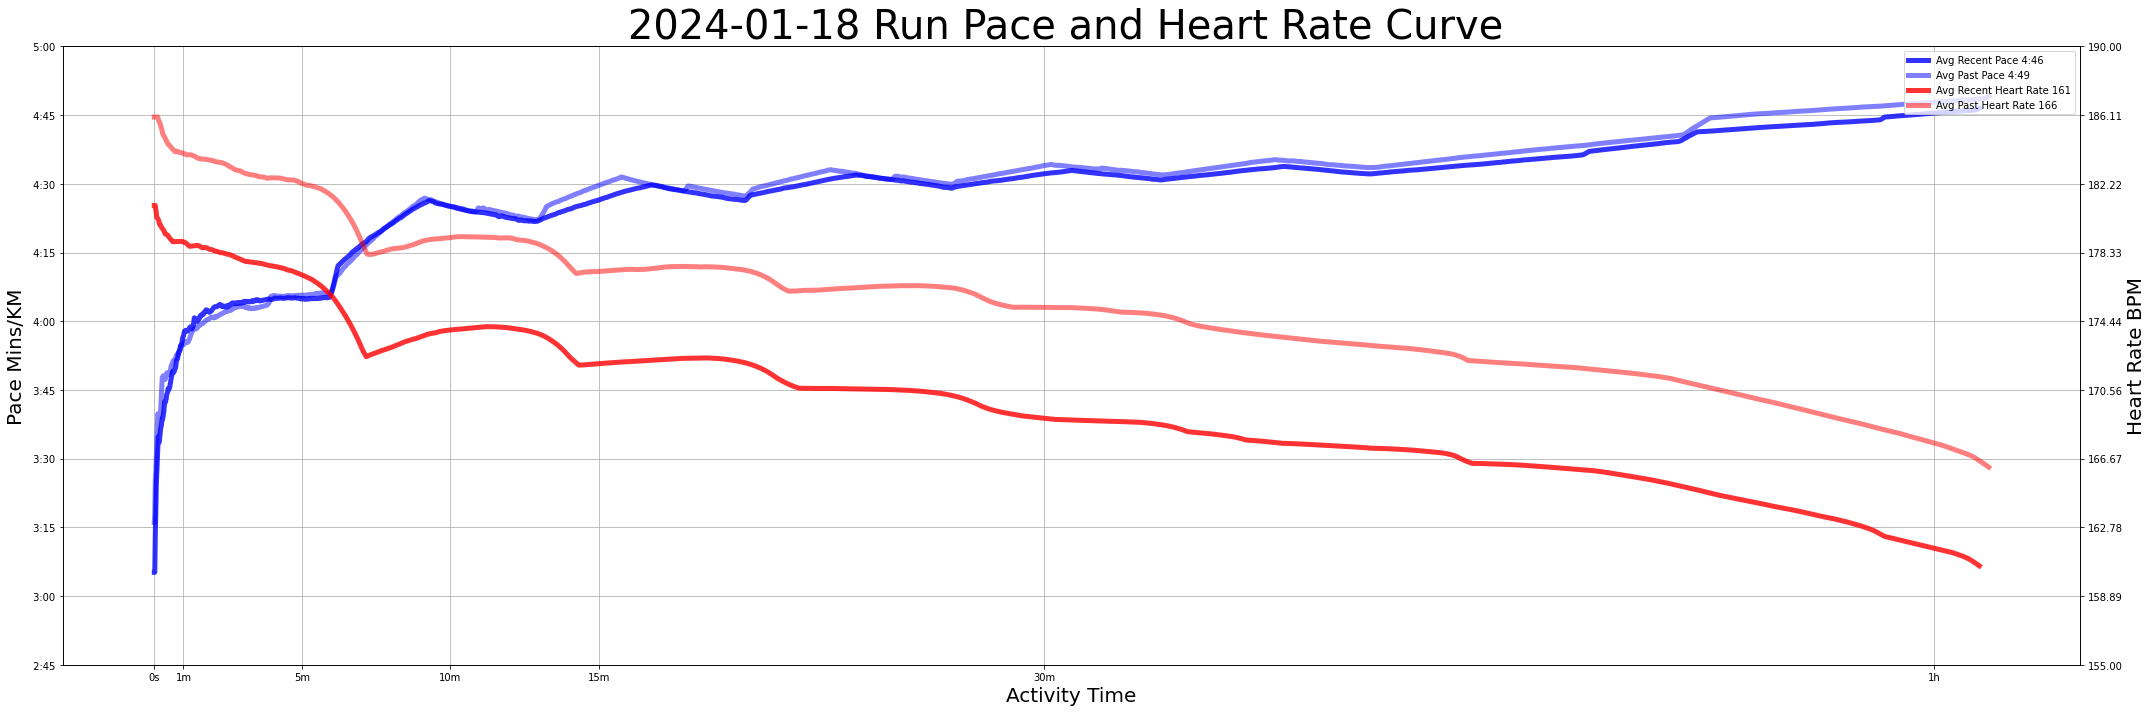

In [32]:
# plot properties
fig, ax1 = plt.subplots(figsize=(30, 10)) # make the plot
plt.title(f'{str(pace["timestamp_None"].dt.date.unique()[0])} Run Pace and Heart Rate Curve ', fontsize = 40) # title the plot

# primary plot
sp = ax1.plot(speed["timestamp_None"], speed["speed_pace"], color="blue", alpha=0.8, linewidth=5, label=f'Avg Recent Pace{y_tick_conversion(mins_per_km(pace["speed_m/s"].mean()))}') # plot speed pace curve over activity time
sp1 = ax1.plot(speed1["timestamp_None"], speed1["speed_pace"], color="blue", alpha=0.5, linewidth=5, label=f'Avg Past Pace{y_tick_conversion(mins_per_km(pace1["speed_m/s"].mean()))}') # plot speed pace curve over activity time
ax1.set_ylabel("Pace Mins/KM", fontsize = 20) # set the y label for pace
# x ticks
x_max_t = np.max(speed.index.max()) # total seconds in the data
x_max_t = x_max_t/3600 # get the hours
x_max_t = np.floor(x_max_t) # round downwards
x_max_t = int(x_max_t * 3600) # maximum amount of seconds in the data
xlabticks = {"0s": 0, "1m": 60, "5m": 300, "10m": 600, "15m": 900, "30m": 1800, "1h": 3600,  "2h": 7200, "3h": 10800, "4h": 14400, "5h": 18000, "6h": 21600, "7h": 25200, "8h": 28800, "9h": 32400, "10h": 36000, "11h": 39600, "12h": 43200, "13h": 46800, "14h": 50400, "15h": 54000, "16h": 57600, "17h": 61200, "18h": 64800, "19h": 68400, "20h": 72000, "21h": 75600, "22h": 79200, "23h": 82800} # dictionary of the x labels and ticks
max_labels = len([value for value in list(xlabticks.values()) if value < np.max(pace.index.max())]) # number of maximum x ticks and labels for the data
plt.xticks(ticks=list(xlabticks.values())[:max_labels], labels=list(xlabticks.keys())[:max_labels]) # set the x ticks
plt.grid() # make a grid
plt.xlabel("Activity Time", fontsize = 20) # x label

# y ticks
ylabticks = [y_tick_conversion(tick) for tick in (plt.yticks()[0])] # list of y labels and ticks
plt.yticks(ticks=plt.yticks()[0], labels=ylabticks) # set the y ticks

# seondary plot
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
hr = ax2.plot(speed["timestamp_None"], speed["heart_rate"], color="red", alpha=0.8, linewidth=5, label=f'Avg Recent Heart Rate {pace["heart_rate_bpm"].mean().__round__()}') # plot heart rate curve over activity time
hr1 = ax2.plot(speed1["timestamp_None"], speed1["heart_rate"], color="red", alpha=0.5, linewidth=5, label=f'Avg Past Heart Rate {pace1["heart_rate_bpm"].mean().__round__()}') # plot heart rate curve over activity time
ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
ax2.set_ylabel("Heart Rate BPM", fontsize = 20) # set the y label for heart rate

# added these three lines
lns = sp+sp1+hr+hr1
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

# show the plot
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show() # show the plot

